# CASA0006 DSSS: Final Assessment

**Author:** Joe Post  
**Student Number:** 22186870  
**Date:** April 2023  

**Word count**: 2,012

**[Github repository](https://github.com/joepost/casa0006_assessment)**  

---

# Predicting crash severity using New Zealand transport data

## 1. Introduction

### 1.1 Background 

This notebook presents the development and evaluation of a machine learning model applied to a New Zealand traffic crash dataset, to predict crash injury severity and determine the most influential contributing factors. 

### 1.2 Literature Review

Vehicle crash injuries present a major public health and economic burden on a global scale. In New Zealand, the government has implemented an explicit ‘Road to Zero’ strategy which aims for a road system where nobody is killed or seriously injured (New Zealand Government, 2019). In response to this complex challenge there is an extensive body of research, developed over decades, that has applied statistical and machine learning models to determine contributing factors in crash likelihood and improve prediction of crash severity (Savolainen et al., 2011; Santos, Dias and Amado, 2022). Understanding the association of specific factors with crash outcomes allows for the design of evidence-based countermeasures, whether in the vehicle or in the built environment, whilst predictive capacity has potential implications for directing emergency response, and in the decision making of autonomous vehicles. 

In recent years, there has been a broad spectrum of ML methods that have rapidly become the most popular choice for crash severity analysis due to their freedom from prior assumptions, robustness to outliers, and high performance in big data scenarios (Ziakopoulos and Yannis, 2020). Established methods include regression and decision trees (Jeong et al., 2018), support vector machines (Effati, Thill and Shabani, 2015), neural networks (Delen et al., 2017), and ensemble approaches such as Random Forest and Gradient Boosting (Iranitalab and Khattak, 2017; Wang and Kim, 2019). Of these various approaches, a systematic literature review by Santos et al. (2022) found that Random Forest (RF) models proved the highest performing algorithm in the most cases, achieving best performance, comparative to alternatives, in 70% of the studies it was applied. 

Irrespective of the approach used, there are certain characteristics of vehicle crash data that need to be accounted for in designing a model. Firstly, these datasets often collect an ordinal categorical outcome – such as crash severity categorised into fatal, serious, minor, or non-injury. These classes are generally heavily imbalanced, with a very high proportion of observations in the low-severity class, and a low proportion classed as severe/fatal. If this imbalance is not addressed, the model may produce overtly promising results with a high overall accuracy, but have very poor predictive performance for the high-severity classes, which are inherently the observations of greatest interest in crash analysis (Jeong et al., 2018). In addition, crash events will have spatial dependence, where crashes occurring geographically close are likely to share effects not otherwise captured in the data, which may introduce bias in model estimates (Savolainen et al., 2011). Therefore, the aim of this study is to develop a reproducible python workflow that evaluates the effectiveness of ensemble ML models in a New Zealand context and quantifies the impact of class imbalance on performance.

 
### 1.3 Research Question

1. How effectively can road and environmental factors predict vehicle crash severity?
1. Of these factors, which have the greatest influence on the prediction performance? 

## 2. Methodology

Data for this analysis are drawn from the New Zealand Transport Agency’s [Crash Analysis System (CAS)](https://opendata-nzta.opendata.arcgis.com/datasets/NZTA::crash-analysis-system-cas-data-1/about), which contains a record of all police-reported traffic crashes on New Zealand roadways from 1st January 2000 (Waka Kotahi NZ Transport Agency, 2023). There are over 70 features captured in the dataset, which can be broken down into road factors (such as number of lanes and speed limit), environmental factors (such as location, weather, and conditions), and crash outcomes (such as objects hit, vehicles involved, and injury severity). 

Two ensemble classification methods, Random Forest (RF) and Adaptive Boosting (AdaBoost), were fitted to a training subset of the data and performance evaluated against a separate testing set. Numeric features were scaled, and one-hot encoding used to separate categorical features. Default models were compared with balanced estimators which use random undersampling to account for the class imbalance. Moran’s I was used to assess for the presence of spatial autocorrelation in the dataset, and a spatial dependence feature added to the model. Lastly, permutation feature importance was used to identify which input features exhibited the strongest influence on model prediction. 

## 3. Data Analysis

### 3.1 Setup
To conduct the analysis, the below packages need to be imported.

In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install imblearn

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import pysal as ps
import libpysal
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import time

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve, cross_validate
from sklearn.metrics import (confusion_matrix, roc_auc_score, balanced_accuracy_score, accuracy_score,
                            precision_score, recall_score, classification_report)
from sklearn.inspection import permutation_importance
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score


# from sklearn.neighbors import NearestNeighbors
# from sklearn.cluster import KMeans, DBSCAN, OPTICS, AgglomerativeClustering

# preprocessors
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector

from imblearn.over_sampling import SMOTE   # run SMOTE (synthetic minority oversampling technique)
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler

# pipeline
from sklearn.pipeline import Pipeline as skPipeline
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.pipeline import make_pipeline

# CART
from sklearn.tree import DecisionTreeRegressor

# random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import BalancedBaggingClassifier

# gradient boosting
import xgboost
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from imblearn.ensemble import EasyEnsembleClassifier

# feature importance
import rfpimp

# spatial dependence
from pysal.explore import esda
from pysal.lib import weights

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('fivethirtyeight') # specifies that graphs should use ggplot styling
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


### 3.2 Data cleaning
#### Read data

In [3]:
# Read in data
df_raw = pd.read_csv("data/Crash_Analysis_System_CAS_data.csv", na_values = "Null")
df_raw.shape

(807933, 72)

#### Clean missing data
The table below shows the default data type of imported columns, and a count of non-null values for each column. There are 807,933 observations (rows) in the dataset, and 72 features (columns).  

In [4]:
# df.dtypes
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 807933 entries, 0 to 807932
Data columns (total 72 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   X                          807933 non-null  float64
 1   Y                          807933 non-null  float64
 2   OBJECTID                   807933 non-null  int64  
 3   advisorySpeed              30681 non-null   float64
 4   areaUnitID                 807883 non-null  float64
 5   bicycle                    807928 non-null  float64
 6   bridge                     325939 non-null  float64
 7   bus                        807928 non-null  float64
 8   carStationWagon            807928 non-null  float64
 9   cliffBank                  325939 non-null  float64
 10  crashDirectionDescription  503841 non-null  object 
 11  crashFinancialYear         807933 non-null  object 
 12  crashLocation1             807933 non-null  object 
 13  crashLocation2             80

Of these, 7 have a very high proportion of missing data (>90% of observations) - they are `advisorySpeed`, `crashRoadSideRoad`, `holiday`, `intersection`, `pedestrian`, `temporarySpeedLimit`, and `weatherB`. These columns contain a mix of true missing data and incorrectly coded real data. For example, `pedestrian` represents a count of how many pedestrians were involved in the crash. However, non-missing values for `pedestrian` range from \[1,6\], meaning that no crash events have a value of '0' recorded. It is reasonable to assume that crashes with a null value for `pedestrian` represent events where no pedestrians were involved. Similarly, `holiday` only records an entry if the event falls into one of the four categories of Christmas/New Year, Easter, Labour Weekend, or Queens Birthday. 

For `temporarySpeedLimit` and `advisorySpeed`, missing data represents a true absence - in these cases, no temporary or advisory speed limit was in effect at the time and location of the crash event. These fields have been converted to boolean - where a present limit is True and no limit classed as False.
The columns `crashRoadSideRoad` and `intersection` are missing all data, and these were removed from the analysis. 

Finally, free-text columns have been removed as these will not be useful in the ML model, as well as a series of redundant fields where the information is contained in another variable. 

In [5]:
checkmissing = df_raw[["pedestrian", "advisorySpeed", 
                   # "holiday", "weatherB",        #commented out as these are non-numeric columns; see cells below
                   "crashRoadSideRoad", "intersection", "temporarySpeedLimit"]]
checkmissing.describe()

,pedestrian,advisorySpeed,crashRoadSideRoad,intersection,temporarySpeedLimit
count,"25,977.0000","30,681.0000",0.0000,0.0000,"12,117.0000"
mean,1.0398,54.4392,NaN,NaN,45.7801
std,0.2309,18.1763,NaN,NaN,19.0041
min,1.0000,10.0000,NaN,NaN,8.0000
25%,1.0000,40.0000,NaN,NaN,30.0000
50%,1.0000,55.0000,NaN,NaN,40.0000
75%,1.0000,65.0000,NaN,NaN,60.0000
max,6.0000,95.0000,NaN,NaN,100.0000


In [6]:
df_raw['holiday'].unique()

array([nan, 'Easter', 'Christmas New Year', 'Labour Weekend',
       'Queens Birthday'], dtype=object)

In [7]:
df_raw['weatherB'].unique()

array([nan, 'Strong wind', 'Frost', 'None'], dtype=object)

In [8]:
df_raw.drop(columns=['OBJECTID', 'areaUnitID', 'crashRoadSideRoad', 'crashDirectionDescription', 'crashFinancialYear', 'crashLocation1', 'crashLocation2', 'meshblockId', 'tlaName', 'tlaId', 'intersection', 'weatherB'], inplace=True)   # drop unwanted columns
df_raw.pedestrian.fillna(value=0, inplace=True)     # replace missing pedestrian values with count of 0
df_raw.holiday.fillna(value="None", inplace=True)   # replace missing holiday values with category 'None'

In [9]:
df_raw.streetLight.fillna(value="Unknown", inplace=True)   # replace missing streetLight values with category 'Unknown'
df_raw.weatherA.fillna(value="Unknown", inplace=True)  # replace missing weather values with category 'unknown'
df_raw.directionRoleDescription.fillna(value="Unknown", inplace=True)  # replace missing direction values with category 'unknown'
df_raw.flatHill.fillna(value="Unknown", inplace=True)  # replace missing hill status with category 'unknown'

In [10]:
temporarySpeedLimit_bool = df_raw["temporarySpeedLimit"].notnull()
df_raw["temporarySpeedLimit_bool"] = temporarySpeedLimit_bool

advisorySpeed_bool = df_raw["advisorySpeed"].notnull()
df_raw["advisorySpeed_bool"] = advisorySpeed_bool

df_raw[["temporarySpeedLimit_bool","advisorySpeed_bool"]]

# REMOVE original tempspeed and advisoryspeed 
df_raw.drop(columns=['temporarySpeedLimit','advisorySpeed'], inplace=True)

A second subset of 23 columns have a non-null count of 325,939, meaning they are missing data for approximately 60% of observations  (Column Set B). These columns all collect data on the number of objects of *type* that were struck in the crash, and are systematically either present or missing. Because of the large set of columns in this group, a subset of the dataframe has been created which keeps these columns but removes observations where they have missing data.

In [11]:
# Set up list of columns with low/no missing data
columnsetA = ['bicycle', 'bus', 'carStationWagon',
           'crashSeverity', 'crashSHDescription', 'crashYear',
           'directionRoleDescription', 'fatalCount', 'flatHill', 'light',
           'minorInjuryCount', 'moped', 'motorcycle', 'NumberOfLanes',
           'otherVehicleType', 'pedestrian', 'region',
           'roadCharacter', 'roadLane', 'roadSurface', 'schoolBus',
           'seriousInjuryCount', 'speedLimit', 'streetLight', 'suv', 'taxi',
           'trafficControl', 'truck', 'unknownVehicleType', 'urban', 'vanOrUtility', 'weatherA']
    
# Set up list of columns with 60% missing data
columnsetB = ['bridge', 'cliffBank', 'debris', 'ditch', 'fence', 'guardRail',
           'houseOrBuilding', 'kerb', 'objectThrownOrDropped', 'otherObject', 'overBank',
           'parkedVehicle', 'phoneBoxEtc', 'postOrPole', 'roadworks', 'slipOrFlood', 'strayAnimal',
           'trafficIsland', 'trafficSign', 'train', 'tree','vehicle','waterRiver']

In [12]:
# Set up subset of dataframe where rows missing data for ColumnSetB are removed
df_cb = df_raw.dropna(axis=0, subset=columnsetB)
df_cb.shape

(325939, 60)

In [13]:
# Use this cell to define the analysis dataset (i.e. df_raw or df_cb)
# The default is to use the ColumnSetB subset
df = df_cb

After removing unnecessary columns and creating the ColumnSetB subset of the dataframe, the data is checked for any remaining missing values. The missing values in these columns all represent a very small percentage (<0.05%) of the total observations. Therefore, these observations have been removed. 

In [14]:
n_total = df.X.count()
missing = pd.DataFrame(df.isna().sum(axis=0))
missing.rename(columns={0:'nullcount'}, inplace=True)
missing["null_pc"]=missing["nullcount"]/n_total

missing[missing["null_pc"]>0]

,nullcount,null_pc
fatalCount,1,0.0000
minorInjuryCount,1,0.0000
NumberOfLanes,636,0.0020
region,750,0.0023
roadLane,209,0.0006
roadSurface,385,0.0012
seriousInjuryCount,1,0.0000
speedLimit,362,0.0011


In [15]:
# remove any remaining observations with missing data
df = df.dropna(axis="index")
df.shape

(323995, 60)

#### Dependent variable
The outcome variable of interest for this study is the `crashSeverity`, which categorises all events as Non-injury, Minor, Serious, or Fatal. Due to the low event counts 'Fatal Crash' and 'Serious Crash' have been combined into a single category for the analysis.

In [16]:
df['crashSeverity_3cat'] = np.where(df['crashSeverity']=='Fatal Crash', 'Serious/Fatal Crash', 
                                    np.where(df['crashSeverity']=='Serious Crash', 'Serious/Fatal Crash', 
                                             df['crashSeverity']))

df[["crashSeverity", "crashSeverity_3cat"]]

,crashSeverity,crashSeverity_3cat
0,Minor Crash,Minor Crash
1,Fatal Crash,Serious/Fatal Crash
2,Fatal Crash,Serious/Fatal Crash
4,Serious Crash,Serious/Fatal Crash
6,Minor Crash,Minor Crash
...,...,...
807924,Non-Injury Crash,Non-Injury Crash
807925,Non-Injury Crash,Non-Injury Crash
807926,Non-Injury Crash,Non-Injury Crash
807928,Non-Injury Crash,Non-Injury Crash


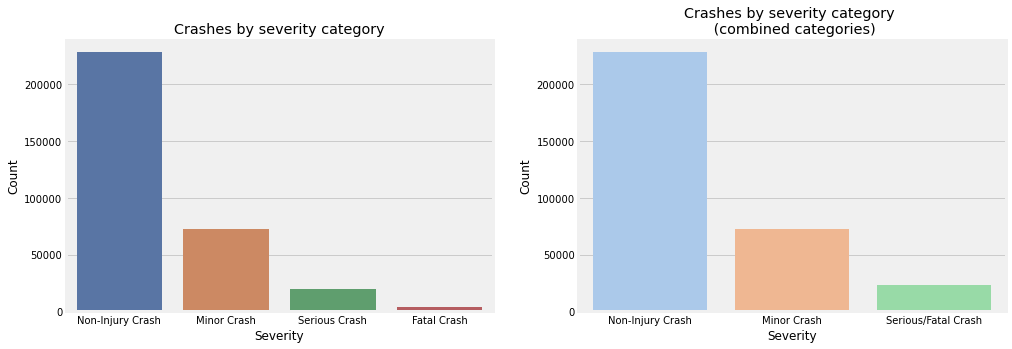

In [17]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))

# create chart in each subplot
sa1 = sns.countplot(data=df, x='crashSeverity', order=['Non-Injury Crash', 'Minor Crash', 'Serious Crash', 'Fatal Crash'], ax=axes[0], palette="deep").set(
    title="Crashes by severity category", xlabel="Severity", ylabel="Count")
sa2 = sns.countplot(data=df, x='crashSeverity_3cat', order=['Non-Injury Crash', 'Minor Crash', 'Serious/Fatal Crash'], ax=axes[1], palette="pastel").set(
    title="Crashes by severity category \n (combined categories)", xlabel="Severity", ylabel="Count")

plt.show()

#### Set data types
Categorical features are set as type accordingly, and the levels for each category checked to ensure it matches the metadata provided. See below for a summary table (Table 1) of each categorical column, broken down proportionally by category. Tables 2 & 3 show the descriptive statistics for numeric variables, for column sets A and B, respectively.

In [18]:
# Convert category columns to category type
df = df.astype({
    "region":"category",
    "crashSeverity":"category",
    "crashSeverity_3cat":"category",
    "crashSHDescription":"category",
    "directionRoleDescription":"category",
    "flatHill":"category",
    "holiday":"category",
    "light":"category",
    "roadCharacter":"category",
    "roadLane":"category",
    "roadSurface":"category",
    "streetLight":"category",
    "trafficControl":"category",
    "urban":"category",
    "weatherA":"category"
})

catcols = ["region", "crashSeverity", "crashSeverity_3cat", "crashSHDescription", "directionRoleDescription", "flatHill",
           "holiday", "light", "roadCharacter", "roadLane", "roadSurface", "streetLight", "trafficControl", "urban", "weatherA", 
           # include boolean columns
          "temporarySpeedLimit_bool", "advisorySpeed_bool"]

##### Table 1.  Categorical variables in crash dataset

In [19]:
# create loop of categorical variables to produce summary tables
for i in catcols:
    agg_df = df[[i, 'X']].groupby(i).count().rename(columns={'X':'count'}).sort_values('count', axis=0, ascending=False)
    total = agg_df.sum().values   # store the total as a value
    agg_df['percent'] = round(agg_df['count']/total*100,2)   # calculate row-wise percentage
    print(agg_df)   # print table
    print("\n")

                           count                                  percent
region                                                                   
Auckland Region            90216                                  27.8400
Waikato Region             40554                                  12.5200
Canterbury Region          31554                                   9.7400
Wellington Region          30921                                   9.5400
Otago Region               22147                                   6.8400
Manawatū-Whanganui Region  21349                                   6.5900
Bay of Plenty Region       18333                                   5.6600
Northland Region           16378                                   5.0600
Hawke's Bay Region         14141                                   4.3600
Southland Region            9945                                   3.0700
Taranaki Region             8540                                   2.6400
Gisborne Region             4731      

##### Table 2. Numeric variables in crash data set (Set A: low/no missing data)

In [20]:
df[columnsetA].describe()

,bicycle,bus,carStationWagon,crashYear,fatalCount,minorInjuryCount,moped,motorcycle,NumberOfLanes,otherVehicleType,pedestrian,schoolBus,seriousInjuryCount,speedLimit,suv,taxi,truck,unknownVehicleType,vanOrUtility
count,"323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000"
mean,0.0067,0.0112,1.0831,"2,011.1227",0.0131,0.3070,0.0023,0.0199,2.0989,0.0053,0.0062,0.0005,0.0745,71.4622,0.0824,0.0055,0.0693,0.0026,0.1402
std,0.0839,0.1069,0.7220,6.5563,0.1293,0.6300,0.0488,0.1445,0.6768,0.0734,0.0907,0.0227,0.3145,24.1654,0.2877,0.0783,0.2632,0.0520,0.3658
min,0.0000,0.0000,0.0000,"2,000.0000",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.0000,0.0000,1.0000,"2,006.0000",0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,50.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,0.0000,0.0000,1.0000,"2,011.0000",0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,50.0000,0.0000,0.0000,0.0000,0.0000,0.0000
75%,0.0000,0.0000,1.0000,"2,017.0000",0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,100.0000,0.0000,0.0000,0.0000,0.0000,0.0000
max,5.0000,3.0000,11.0000,"2,022.0000",7.0000,26.0000,4.0000,6.0000,8.0000,2.0000,6.0000,2.0000,14.0000,110.0000,6.0000,5.0000,5.0000,3.0000,6.0000


##### Table 3. Numeric variables in crash data set (Set B: approx. 60% missing data)

In [21]:
df[columnsetB].describe()

,bridge,cliffBank,debris,ditch,fence,guardRail,houseOrBuilding,kerb,objectThrownOrDropped,otherObject,...,postOrPole,roadworks,slipOrFlood,strayAnimal,trafficIsland,trafficSign,train,tree,vehicle,waterRiver
count,"323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000",...,"323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000","323,995.0000"
mean,0.0136,0.1064,0.0080,0.0950,0.2106,0.0763,0.0234,0.0353,0.0022,0.0233,...,0.1233,0.0028,0.0024,0.0032,0.0288,0.0486,0.0015,0.1012,0.0254,0.0098
std,0.1173,0.3096,0.0980,0.2956,0.4127,0.2713,0.1521,0.1854,0.0511,0.1529,...,0.3310,0.0549,0.0505,0.0608,0.1688,0.2167,0.0387,0.3050,0.1592,0.0990
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
75%,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
max,4.0000,3.0000,7.0000,3.0000,3.0000,4.0000,2.0000,3.0000,4.0000,5.0000,...,4.0000,2.0000,4.0000,3.0000,4.0000,4.0000,1.0000,3.0000,4.0000,2.0000


#### Spatial conversion
The pandas dataframe is converted into a geopandas geodataframe, using the X/Y coordinates provided \([NZTM2000](https://www.linz.govt.nz/guidance/geodetic-system/coordinate-systems-used-new-zealand/projections/new-zealand-transverse-mercator-2000-nztm2000) easting/northing values\). The geodataframe is then plotted to confirm that the projection has been read as expected. 

A spatial weights matrix is then generated using the *k*-nearest neighbours (KNN) method, where *k*=8, and the distance band method with a threshold of 100m. Global spatial autocorrelation is then calculated using the KNN weights to ensure no neighbourless points. 

In [22]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.X, df.Y), crs = "EPSG:2193") 
gdf.shape

(323995, 62)

Text(0.5, 1.0, 'Traffic Crash Locations, New Zealand, 2000-2022')

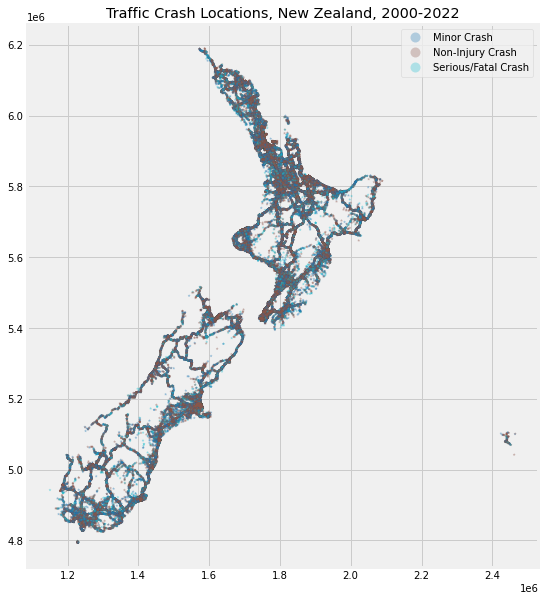

In [23]:
fig, ax = plt.subplots(figsize = (10,10))
gdf.plot(marker='*', 
         # color='blue', 
         column='crashSeverity_3cat',
         alpha=0.3,
         legend=True,
         markersize=5,
        ax=ax)
ax.set_title('Traffic Crash Locations, New Zealand, 2000-2022')

In [24]:
# Generate Weights matrix from the GeoDataFrame
w_knn = weights.KNN.from_dataframe(gdf, k=8)
# Row-standardization
w_knn.transform = "R"

w_knn.weights[4]

[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]

In [25]:
w_bdb = weights.distance.DistanceBand.from_dataframe(
    gdf, 100, binary=True
)

w_bdb.weights[4]  # show the neighbour weights for observation 4

[1.0, 1.0]

In [26]:
# Calculate combined injury count measure
# Use this as a numeric input for spatial autocorrelation calculations, that acts as proxy for crash severity category
gdf["injuryCount"] = (gdf.minorInjuryCount + gdf.seriousInjuryCount).astype('int')             # raw count
gdf["IC_std"] = (gdf["injuryCount"] - gdf["injuryCount"].mean()) / gdf["injuryCount"].std()    # standardised 

In [27]:
# Calculate spatial lag

#define weights measure to use
w = w_knn

gdf["IC_lag"] = weights.spatial_lag.lag_spatial(w, gdf["injuryCount"])    # create column: injury count spatial lag
gdf["IC_std_lag"] = weights.spatial_lag.lag_spatial(w, gdf["IC_std"])     # create column: std injury count spatial lag

gdf[["injuryCount", "crashSeverity_3cat", "IC_lag", "IC_std", "IC_std_lag"]]

,injuryCount,crashSeverity_3cat,IC_lag,IC_std,IC_std_lag
0,1,Minor Crash,0.2500,0.8534,-0.1813
1,2,Serious/Fatal Crash,0.2500,2.2331,-0.1813
2,1,Serious/Fatal Crash,0.3750,0.8534,-0.0089
4,5,Serious/Fatal Crash,0.8750,6.3722,0.6810
6,3,Minor Crash,0.6250,3.6128,0.3361
...,...,...,...,...,...
807924,0,Non-Injury Crash,0.0000,-0.5262,-0.5262
807925,0,Non-Injury Crash,0.2500,-0.5262,-0.1813
807926,0,Non-Injury Crash,0.3750,-0.5262,-0.0089
807928,0,Non-Injury Crash,0.2500,-0.5262,-0.1813


The Moran plot below represents a scatter plot of the injury count against its spatial lag. The fitted regression line demonstrates a positive relationship between both variables, which indicates the presence of spatial autocorrelation in the data – for example, crashes with a high injury count are likely to be geographically close to other high-injury crashes. The global Moran’s I statistic of 0.74 (p-value < 0.01) confirms this assumption. 

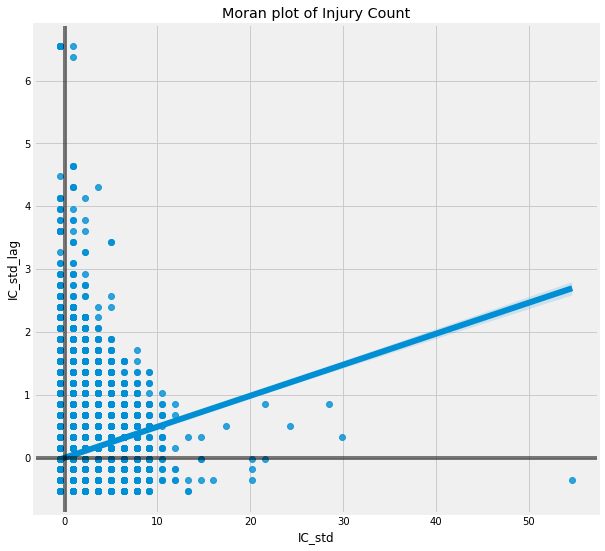

In [28]:
# Plot Moran plot

# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='IC_std', y='IC_std_lag', data=gdf).set(title="Moran plot of Injury Count")
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

In [29]:
# Calculate Moran's I statistic
mi = esda.Moran(gdf['IC_std_lag'], w)
print(f"Moran's I value: {round(mi.I,3)}; p-value: {mi.p_sim}")

Moran's I value: 0.744; p-value: 0.001


Effati et al. (2015) propose accounting for spatial autocorrelation in a decision tree model by incorporating the coordinates as features in addition to a spatial dependence term. In this case, the standardised injury count spatial lag has been added to the model dataset and the additional columns are dropped. 

In [30]:
# remove features that will not be included in ML model
gdf.drop(columns=['injuryCount', 'IC_lag', 'IC_std'], inplace=True)

### 3.3 Fitting and evaluating a model
#### Training Testing Split
Firstly, the dataset is split into training and testing subsets, before any of the preprocessing steps take place. This ensures that there is no data leakage from the testing set, which can lead to inflated performance estimates (Tharwat, 2020). 

In [31]:
# Set inputs for model
data = gdf    # alternative: full dataset 'gdf'
y_var = 'crashSeverity_3cat'

In [32]:
dataX = data.drop(columns=['crashSeverity', 'crashSeverity_3cat'
                           , 'seriousInjuryCount', 'minorInjuryCount', 'fatalCount'
                           # , 'X', 'Y'
                          ])  # create df containing only the predictor variables
dataY = data[y_var]  # create array containing only the classifications/labels

random_state_split = 50
train_x, test_x, train_y, test_y = train_test_split(dataX, dataY, random_state=random_state_split)

In [33]:
print(f"Full dataset size: {data.shape}")

print("Training dataset size:")
print(train_x.shape)
print(train_y.shape)
      
print("Test dataset size:")
print(test_x.shape)
print(test_y.shape)

Full dataset size: (323995, 63)
Training dataset size:
(242996, 58)
(242996,)
Test dataset size:
(80999, 58)
(80999,)


#### Model Pipeline
To prepare the data for modelling, two pre-processing steps are run: standardisation of numeric variables and one-hot encoding of categorical variables. After defining the pre-processing steps, an estimator is added to the ML pipeline. For this project, a remote forest classifier (Breiman, 2001) has been chosen.

In [34]:
# Define preprocessors
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

numerical_columns_selector = make_column_selector(dtype_include="number")
categorical_columns_selector = make_column_selector(dtype_exclude=["number", "geometry"])

numerical_columns = numerical_columns_selector(data)
categorical_columns = categorical_columns_selector(data)

In [35]:
# Prepare numeric and categorical column lists

numerical_columns.remove('seriousInjuryCount')   # remove the dependent variables
numerical_columns.remove('fatalCount')           # remove the dependent variables
numerical_columns.remove('minorInjuryCount')           # remove the dependent variables

# numerical_columns.remove('X')           # remove the dependent variables
# numerical_columns.remove('Y')           # remove the dependent variables

categorical_columns.remove('crashSeverity')        # remove the dependent variable
categorical_columns.remove('crashSeverity_3cat')   # remove the dependent variable

catcols_index = [train_x.columns.get_loc(col) for col in categorical_columns]

In [36]:
column_preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, numerical_columns),          # tuple that sets out the name, the transformer to use, and the set of columns to include
        ('categorical', categorical_transformer, categorical_columns)
    ])

In [37]:
#imblearn estimator
rf_model=make_pipeline(column_preprocessor, RandomForestClassifier(random_state=random_state_split))
rf_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['X', 'Y', 'bicycle',
                                                   'bridge', 'bus',
                                                   'carStationWagon',
                                                   'cliffBank', 'crashYear',
                                                   'debris', 'ditch', 'fence',
                                                   'guardRail',
                                                   'houseOrBuilding', 'kerb',
                                                   'moped', 'motorcycle',
                                                   'NumberOfLanes',
                                                   'objectThrownOrDropped',
                                                   'otherObject',
                                                   'otherVehicleType',
                                                   'overBank', 'parkedVeh...
                                                   'speedLimit', 'strayAnimal', ...]),
                                                 ('categorical',
                                                  OneHotEncoder(),
                                                  ['crashSHDescription',
                                                   'directionRoleDescription',
                                                   'flatHill', 'holiday',
                                                   'light', 'region',
                                                   'roadCharacter', 'roadLane',
                                                   'roadSurface', 'streetLight',
                                                   'trafficControl', 'urban',
                                                   'weatherA',
                                                   'temporarySpeedLimit_bool',
                                                   'advisorySpeed_bool'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=50))])

In [38]:
start_time = time.time()

rf_model_fit = rf_model.fit(train_x, train_y)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the model: {round((elapsed_time)/60,2)} minutes")

Elapsed time to compute the model: 2.54 minutes


In [39]:
# Evaluate random forest model
print(f"Training score: {rf_model_fit.score(train_x, train_y)}")
print(f"Test score: {rf_model_fit.score(test_x, test_y)}")

Training score: 0.9999876541177632
Test score: 0.7101569155174755


#### Evaluating performance
The classification report below lists a set of performance metrics designed to evaluate imbalanced datasets: precision, recall, specificity, F1 score, geometric mean (G-mean), and index balanced accuracy of the G-mean. The G-mean, calculated as the square root of the product of sensitivity and specificity measures, has been proposed as a more appropriate metric for evaluating models developed from imbalanced datasets (Jeong et al. 2018). Additionally, the `balanced_accuracy_score` function computes the balanced accuracy, which avoids inflated performance estimates on imbalanced datasets. 

The results below show that the default random forest model performs poorly for the severe/fatal class.

In [40]:
y_predict = rf_model.predict(test_x)
y_true = test_y

In [41]:
print(classification_report_imbalanced(y_true, y_predict))

                           pre       rec       spe        f1       geo       iba       sup

        Minor Crash       0.44      0.11      0.96      0.17      0.32      0.10     18311
   Non-Injury Crash       0.73      0.97      0.15      0.83      0.39      0.16     56881
Serious/Fatal Crash       0.48      0.08      0.99      0.14      0.29      0.08      5807

        avg / total       0.65      0.71      0.40      0.63      0.37      0.14     80999



In [42]:
print(f"The accuracy score is: {round(accuracy_score(y_true, y_predict),3)}")
print(f"The balanced accuracy score is: {round(balanced_accuracy_score(y_true, y_predict),3)}")

The accuracy score is: 0.71
The balanced accuracy score is: 0.387


#### Iterate through multiple models

After testing proof-of-concept with the RF model above, a loop is built to iterate through alternative ensemble models and compare the performance results. In the ML literature, there are two main approaches to dealing with class imbalanced data: under-sampling and over-sampling (Wen et al. 2019). Due to the large size of the cleaned dataset (still over 300,000 observations), an undersampling method has been applied, as this maintains a high performance but at significantly reduced computational load.

In [43]:
# Compare multiple model variations in a single method
start_time = time.time()

classifiers = {
    'RF': RandomForestClassifier(random_state=random_state_split),
    'RF_balanced': BalancedRandomForestClassifier(random_state=random_state_split),
    'BBC': BalancedBaggingClassifier(sampler=RandomUnderSampler(), random_state=random_state_split),
    'AdaBoost': EasyEnsembleClassifier(random_state=random_state_split)
}

# a dict to store the evaluation output of training and testing data
dict_results = dict()

for name, classifier in classifiers.items():
    model = imbPipeline(steps = [
   ('column_preprocessor', column_preprocessor),
   ('classifier', classifier)
    ])

    model_fit = model.fit(train_x, train_y)

    y_predict = model_fit.predict(test_x)
    y_predict_train = model_fit.predict(train_x)

    # predictions = model.predict(test_x)
    dict_results[name] = [model_fit.score(train_x, train_y),   # accuracy score of training data
                          model_fit.score(test_x, test_y),     # accuracy score of test data
                          balanced_accuracy_score(test_y, y_predict),  # balanced accuracy 
                          geometric_mean_score(test_y, y_predict)   # geometric mean
                         ]

# transform dict_models to dataframe
df_models = pd.DataFrame.from_dict(dict_results, orient='index', 
                                   columns=['Training accuracy', 'Testing accuracy', 'Balanced testing accuracy', 'G-Mean'])

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the model iteration: {round((elapsed_time)/60,2)} minutes")

Elapsed time to compute the model iteration: 11.13 minutes


Of the four models tested, the balanced RF and balanced adaptive booster (AdaBoost) perform the best in balanced accuracy and G-mean, with roughly equivalent values of **0.49** and **0.48**, respectively. As the RF performs marginally better, this model is chosen for the final analysis. 

##### Table 4. Comparison of model performance

In [44]:
df_models

,Training accuracy,Testing accuracy,Balanced testing accuracy,G-Mean
RF,1.0000,0.7102,0.3868,0.2066
RF_balanced,0.7296,0.5172,0.4909,0.4836
BBC,0.7144,0.5256,0.4533,0.4431
AdaBoost,0.5392,0.5378,0.4933,0.4790


In [45]:
# Define final model as Balanced RF
rf_model=make_pipeline(column_preprocessor, BalancedRandomForestClassifier(random_state=random_state_split))
rf_model_fit = rf_model.fit(train_x, train_y)

rf_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['X', 'Y', 'bicycle',
                                                   'bridge', 'bus',
                                                   'carStationWagon',
                                                   'cliffBank', 'crashYear',
                                                   'debris', 'ditch', 'fence',
                                                   'guardRail',
                                                   'houseOrBuilding', 'kerb',
                                                   'moped', 'motorcycle',
                                                   'NumberOfLanes',
                                                   'objectThrownOrDropped',
                                                   'otherObject',
                                                   'otherVehicleType',
                                                   'overBank', 'parkedVeh...
                                                   'speedLimit', 'strayAnimal', ...]),
                                                 ('categorical',
                                                  OneHotEncoder(),
                                                  ['crashSHDescription',
                                                   'directionRoleDescription',
                                                   'flatHill', 'holiday',
                                                   'light', 'region',
                                                   'roadCharacter', 'roadLane',
                                                   'roadSurface', 'streetLight',
                                                   'trafficControl', 'urban',
                                                   'weatherA',
                                                   'temporarySpeedLimit_bool',
                                                   'advisorySpeed_bool'])])),
                ('balancedrandomforestclassifier',
                 BalancedRandomForestClassifier(random_state=50))])

#### Hyperparameter tuning
The following method finds the optimal values for RF hyperparameters, from the specified set. For this model, the best performing set used a max tree depth of 50 and a minimum leaf sample of 2.   

**NOTE:** The tuning cell takes >1 hour to run. Therefore, has been default set to not run, unless explicitly called by setting `run_tuning` to True.

In [46]:
# Set the below to 'True' to run the hyperparameter tuning cell
run_tuning = False

In [47]:
if run_tuning == True:
    start_time = time.time()
    
    # grid_params is the range of each hyperparameter
    grid_params = {  
        'randomforestclassifier__max_depth': [10,20,30,40,50],           #NOTE: the identifier of this name needs to change to match the model estimator
        'randomforestclassifier__min_samples_split': [2,4,6,8]   
    }
    search = GridSearchCV(rf_model, 
                      grid_params, 
                      verbose=2)    # controls the message output; v=2 computation time for each fold and parameter candidate are displayed
    search.fit(train_x, train_y)
    print("Best Score: ", search.best_score_)
    print("Best Params: ", search.best_params_)
    
    elapsed_time = time.time() - start_time
    print(f"Elapsed time to compute the hyperparameter tuning: {round((elapsed_time)/60,2)} minutes")
    
else:
    print("Hyperparameter tuning not run.")

Hyperparameter tuning not run.


In [54]:
# Update final model using values from hyperparameter tuning
rf_model=make_pipeline(column_preprocessor, 
                       BalancedRandomForestClassifier(
                           random_state=random_state_split,
                           min_samples_split=2,
                           max_depth=50
                       ))
rf_model_fit = rf_model.fit(train_x, train_y)

rf_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['X', 'Y', 'bicycle',
                                                   'bridge', 'bus',
                                                   'carStationWagon',
                                                   'cliffBank', 'crashYear',
                                                   'debris', 'ditch', 'fence',
                                                   'guardRail',
                                                   'houseOrBuilding', 'kerb',
                                                   'moped', 'motorcycle',
                                                   'NumberOfLanes',
                                                   'objectThrownOrDropped',
                                                   'otherObject',
                                                   'otherVehicleType',
                                                   'overBank', 'parkedVeh...
                                                 ('categorical',
                                                  OneHotEncoder(),
                                                  ['crashSHDescription',
                                                   'directionRoleDescription',
                                                   'flatHill', 'holiday',
                                                   'light', 'region',
                                                   'roadCharacter', 'roadLane',
                                                   'roadSurface', 'streetLight',
                                                   'trafficControl', 'urban',
                                                   'weatherA',
                                                   'temporarySpeedLimit_bool',
                                                   'advisorySpeed_bool'])])),
                ('balancedrandomforestclassifier',
                 BalancedRandomForestClassifier(max_depth=50,
                                                random_state=50))])

#### Cross-validation

In [55]:
# Perform cross-validation
start_time = time.time()

cv_results = cross_validate(rf_model, train_x, train_y, cv=5, scoring='balanced_accuracy')

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the cross-validation: {round((elapsed_time)/60,2)} minutes")

Elapsed time to compute the cross-validation: 2.54 minutes


##### Table 5. Cross-validation results

In [56]:
pd.DataFrame.from_dict(cv_results,orient = 'index')

,0,1,2,3,4
fit_time,27.9161,28.2616,26.7871,28.9202,25.9665
score_time,2.7313,2.8676,2.6664,2.9370,2.6816
test_score,0.4917,0.4888,0.4856,0.4833,0.4952


In [50]:
scores = cv_results["test_score"]
print("The mean cross-validation balanced accuracy is: "
      f"{scores.mean():.3f} ± {scores.std():.3f}")

The mean cross-validation balanced accuracy is: 0.488 ± 0.002


In [51]:
y_predict = rf_model_fit.predict(test_x)
y_true = test_y

print(classification_report_imbalanced(y_true, y_predict))

                           pre       rec       spe        f1       geo       iba       sup

        Minor Crash       0.30      0.38      0.74      0.33      0.53      0.27     18311
   Non-Injury Crash       0.84      0.56      0.74      0.67      0.64      0.41     56881
Serious/Fatal Crash       0.16      0.54      0.78      0.24      0.64      0.41      5807

        avg / total       0.67      0.52      0.74      0.56      0.62      0.38     80999



#### Interpreting feature importance
After refining the best performing model, permutation feature importance (PFI) has been used to identify which features have the greatest influence on prediction. The 'importance' score for each feature is relative to the other features in the other dataset. The number of cars involved, the year, and the speed limit are found to be the strongest predicting features of crash severity.

##### Table 6. Relative feature importance 

In [52]:
imp = rfpimp.importances(rf_model, test_x, test_y)
print(imp)

                                                       Importance
Feature                                                          
carStationWagon                                            0.0214
crashSHDescription                                         0.0152
speedLimit                                                 0.0148
Y                                                          0.0096
weatherA                                                   0.0062
motorcycle                                                 0.0060
fence                                                      0.0060
parkedVehicle                                              0.0056
cliffBank                                                  0.0048
pedestrian                                                 0.0038
bicycle                                                    0.0038
directionRoleDescription                                   0.0036
vanOrUtility                                               0.0032
postOrPole

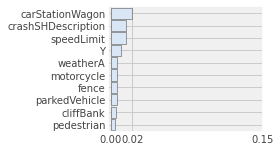

In [53]:
imphead = imp[0:10]
imphead

# Here is a barplot of the feature importance
viz = rfpimp.plot_importances(imphead)
viz.view()

## 4. Discussion & Conclusion

In the final evaluation of models, the balanced random forest performed the best, particularly accounting for prediction of observations in the severe/fatal severity class. However, compared with ML models in other crash severity studies the performance was still relatively low, suggesting that there may be a large amount of unobserved heterogeneity in the New Zealand CAS dataset. As expected, the model was made more complex due to the significant class imbalance and the presence of strong spatial autocorrelation in the crash severity. Model performance may potentially be improved by exploring more computationally intensive methods which were not feasible for the scope of this project – for example, rectifying class imbalance through Synthetic Minority Oversampling Technique (SMOTE), which generates novel observations in the smaller classes through imputation (Fernandez et al., 2018).

The number of cars involved, year, and speed limit had the strongest influence on crash severity. The presence of year indicates there is likely a meaningful time trend in the data – this would be a valuable extension to this study, and provide insight into the long-term success (or failure) of New Zealand’s overarching road safety policy framework.

## References

1. Breiman, L. (2001) ‘Random Forests’, Machine Learning, 45(1), pp. 5–32. Available at: https://doi.org/10.1023/A:1010933404324.

1. Delen, D. et al. (2017) ‘Investigating injury severity risk factors in automobile crashes with predictive analytics and sensitivity analysis methods’, Journal of Transport & Health, 4, pp. 118–131. Available at: https://doi.org/10.1016/j.jth.2017.01.009.

1. Effati, M., Thill, J.-C. and Shabani, S. (2015) ‘Geospatial and machine learning techniques for wicked social science problems: analysis of crash severity on a regional highway corridor’, Journal of Geographical Systems, 17(2), pp. 107–135. Available at: https://doi.org/10.1007/s10109-015-0210-x.

1. Fernandez, A. et al. (2018) ‘SMOTE for Learning from Imbalanced Data: Progress and Challenges, Marking the 15-year Anniversary’, Journal of Artificial Intelligence Research, 61, pp. 863–905. Available at: https://doi.org/10.1613/jair.1.11192.

1. Iranitalab, A. and Khattak, A. (2017) ‘Comparison of four statistical and machine learning methods for crash severity prediction’, Accident Analysis & Prevention, 108, pp. 27–36. Available at: https://doi.org/10.1016/j.aap.2017.08.008.

1. Jeong, H. et al. (2018) ‘Classification of motor vehicle crash injury severity: A hybrid approach for imbalanced data’, Accident Analysis & Prevention, 120, pp. 250–261. Available at: https://doi.org/10.1016/j.aap.2018.08.025.

1. New Zealand Government (2019) Road to Zero: New Zealand’s Road Safety Strategy 2020-2030. Wellington, NZ. Available at: https://www.nzta.govt.nz/safety/what-waka-kotahi-is-doing/nz-road-safety-strategy/.

1. Santos, K., Dias, J.P. and Amado, C. (2022) ‘A literature review of machine learning algorithms for crash injury severity prediction’, Journal of Safety Research, 80, pp. 254–269. Available at: https://doi.org/10.1016/j.jsr.2021.12.007.

1. Savolainen, P.T. et al. (2011) ‘The statistical analysis of highway crash-injury severities: A review and assessment of methodological alternatives’, Accident Analysis & Prevention, 43(5), pp. 1666–1676. Available at: https://doi.org/10.1016/j.aap.2011.03.025.

1. Tharwat, A. (2020) ‘Classification assessment methods’, Applied Computing and Informatics, 17(1), pp. 168–192. Available at: https://doi.org/10.1016/j.aci.2018.08.003.

1. Waka Kotahi NZ Transport Agency (2023) Crash Analysis System (CAS) Open Data. Available at: https://opendata-nzta.opendata.arcgis.com/search?tags=CAS (Accessed: 20 April 2023).

1. Wang, X. and Kim, S.H. (2019) ‘Prediction and Factor Identification for Crash Severity: Comparison of Discrete Choice and Tree-Based Models’, Transportation Research Record, 2673(9), pp. 640–653. Available at: https://doi.org/10.1177/0361198119844456.

1. Ziakopoulos, A. and Yannis, G. (2020) ‘A review of spatial approaches in road safety’, Accident Analysis & Prevention, 135, p. 105323. Available at: https://doi.org/10.1016/j.aap.2019.105323.
